# Scenario

A client approaches you to solve a machine learning problem for them.  They run a pathology lab that processes histological images for healthcare providers and they have created a product that measures the same features as in the *Wisconsin breast cancer data set* though using different acquisitions and processing methods. This makes their method much faster than existing ones, but it is also slightly noisier. They want to be able to diagnose *malignant* cancer (and distinguish them from *benign* growths) by employing machine learning techniques, and they have asked you to implement this for them.

Their requirements are:
 1) have at least a 95% probability of detecting malignant cancer when it is present;
 2) have no more than 1 in 10 healthy cases (those with benign tumours) labelled as positive (malignant).
 
They have hand-labelled 300 samples for you, which is all they have at the moment.


### Investigate Dataset

In [3]:
import sys
assert sys.version_info >= (3, 5)

import numpy as np
import time

import pandas as pd

import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn import tree
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

import seaborn as sns
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### Load the dataset


**Also, graphically show the proportions of the labels in the whole dataset.**

The features are: 
Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')

The labels are: 
['malignant' 'benign']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   label                    300 non-null    object 
 1   mean r

<AxesSubplot:>

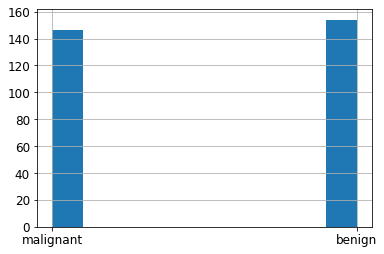

In [4]:

health_data=pd.read_csv("assignment2.csv")


# Extracting feature names and labels
print("The features are: ")
print(health_data.columns[1:])
print()
print("The labels are: ")
print(health_data["label"].unique()) # To know the types of label,I am not converting it to 1,0now I will do it before train_test_split
print()

# Getting the feel of the data
print(health_data.info())   
print(health_data.describe())


# Proportion of labels
# health_data["label"].hist(figsize=(3,2))
health_data["label"].hist()


To familiarise yourself with the nature and information contained in the data, display histograms for the data according to the following instructions:
 - display histograms** for each feature in the _mean_ group, but on _each_ histogram **have the two classes displayed together in one plot.
 - **repeat this** for the _standard error_ and _worst_ groups;
 - make sure that in all cases you clearly label the plots and the classes in histograms.

Plots for Mean Group


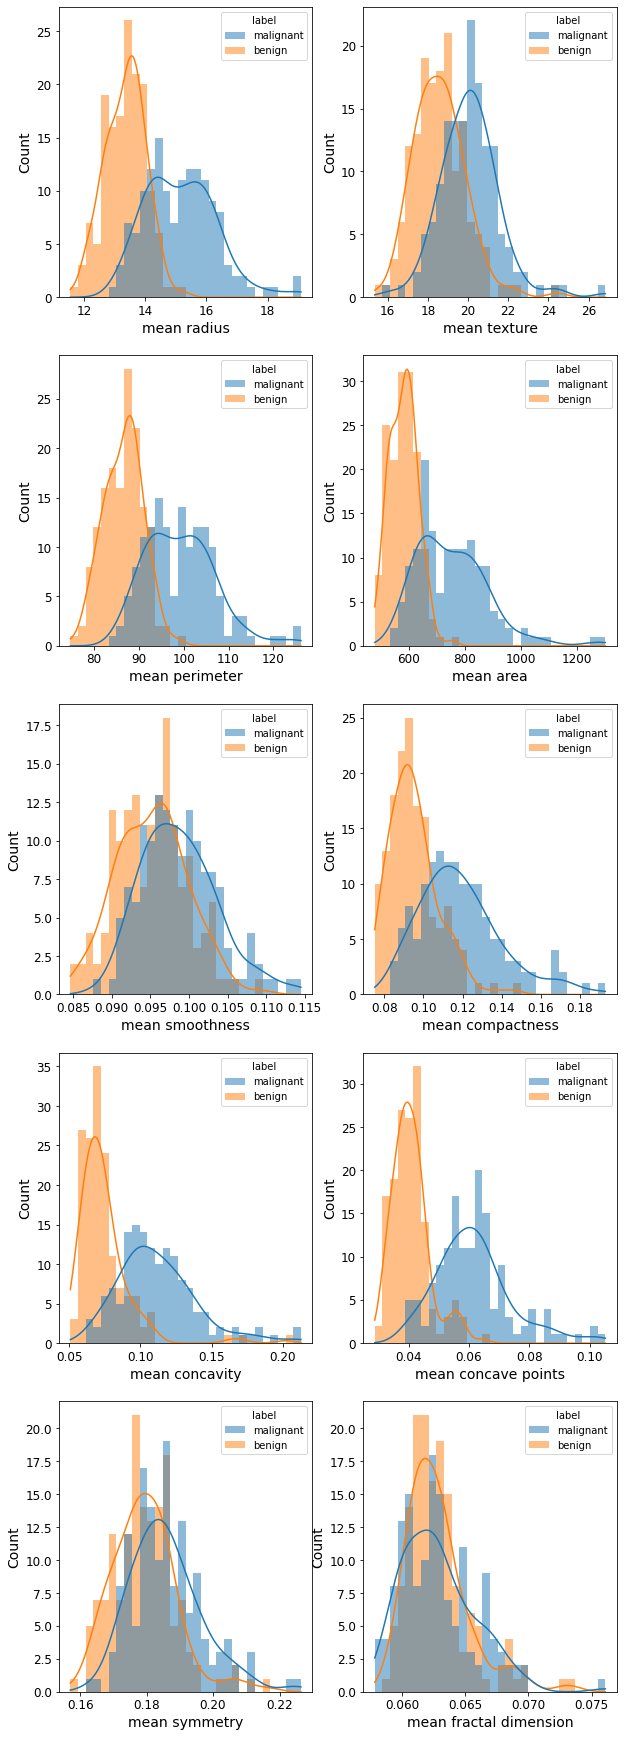

In [5]:
print("Plots for Mean Group")


health_data_mean=health_data.iloc[:,:11]
fig, axes = plt.subplots(5, 2, figsize=(10,31))
q=1
while q<=10:
    for j in range(5):
        for k in range(2):
            sns.histplot(data=health_data_mean, x=health_data_mean.columns[q], hue="label", bins=30, kde=True, ax=axes[j,k], edgecolor=None)
            q+=1

Plots for Standard Error Group


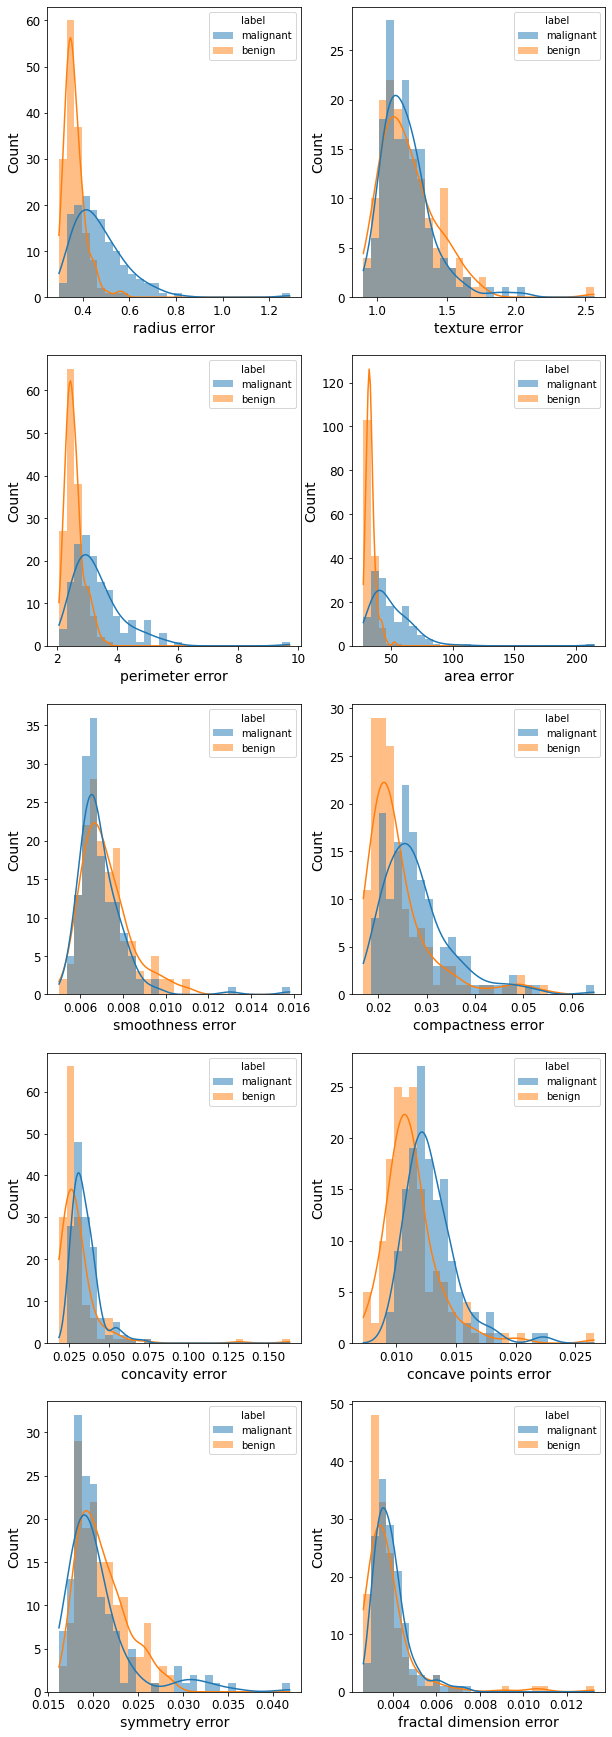

In [6]:
print('Plots for Standard Error Group')

health_data_standard_error=health_data.iloc[:,11:21]
df=health_data["label"]
new_df=pd.concat([df,health_data_standard_error],axis=1)

fig, axes = plt.subplots(5, 2, figsize=(10,31))

q=1
while q<=10:
    for j in range(5):
        for k in range(2):
            sns.histplot(data=new_df, x=new_df.columns[q], hue="label", bins=30, kde=True, ax=axes[j,k], edgecolor=None)
            q+=1

Plots for the Worst Group


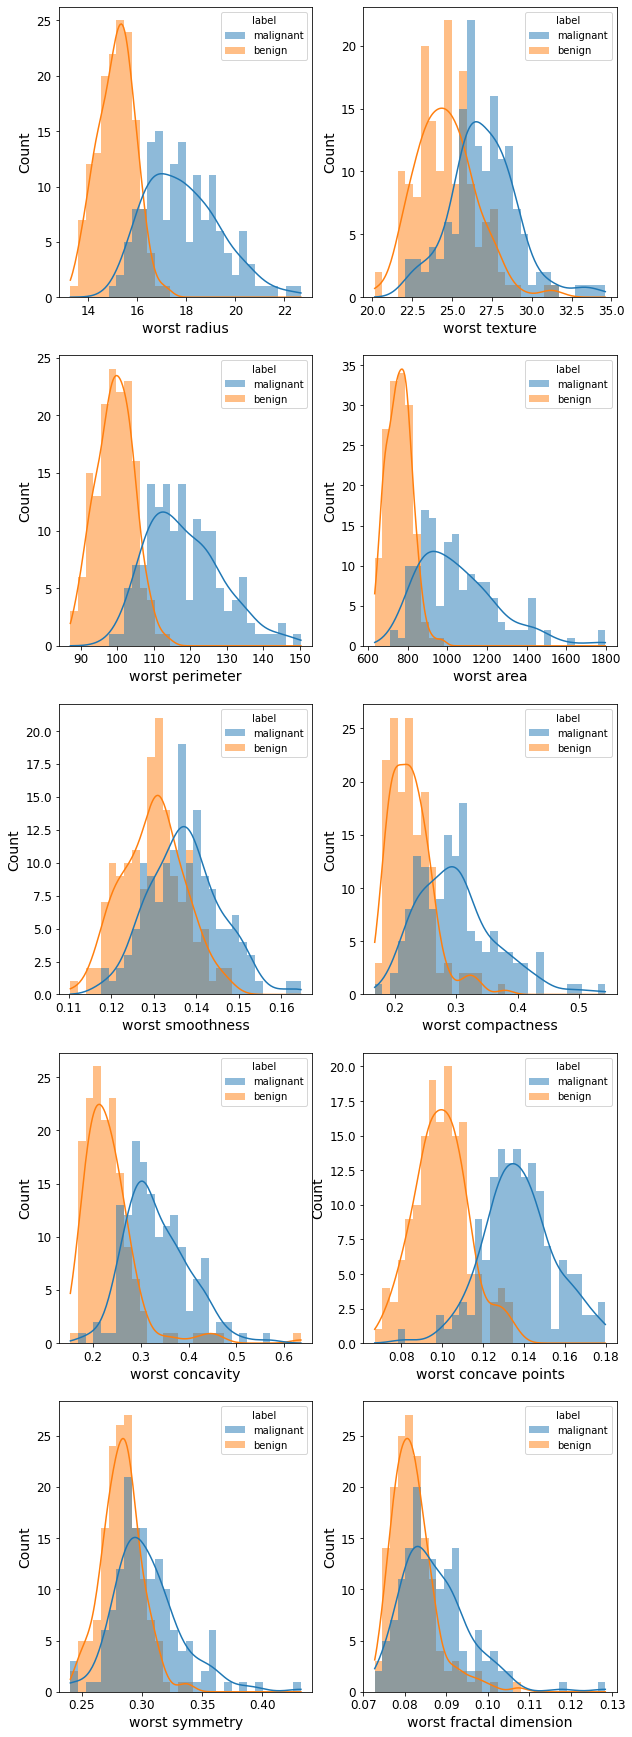

In [7]:
# Worst Group
print('Plots for the Worst Group')

health_data_standard_error=health_data.iloc[:,21:]
df_=health_data["label"]
new_df_=pd.concat([df,health_data_standard_error],axis=1)
new_df_

fig, axes = plt.subplots(5, 2, figsize=(10,31))
q=1
while q<=10:
    for j in range(5):
        for k in range(2):
            sns.histplot(data=new_df_, x=new_df_.columns[q], hue="label", bins=30, kde=True, ax=axes[j,k], edgecolor=None)
            q+=1

### Ranking the features

In [8]:
print('Based on the Histogram I think the most strongest features would be the one with the minimum overlap')
print("But I think that comparing that manually with human eyes is a little hard")
print("The 3 strongest features are: ") 
print("Worst Radius")
print("Worst Area")
print("Worst Perimeter")

Based on the Histogram I think the most strongest features would be the one with the minimum overlap
But I think that comparing that manually with human eyes is a little hard
The 3 strongest features are: 
Worst Radius
Worst Area
Worst Perimeter


### Splitting the dataset 

using the _stratify_ option.

In [9]:

# BECAUSE OF THIS lambda function ,IT IS IMPORTANT TO ONLY RUN THIS CODE CELL ONCE.
health_data["label"]=health_data["label"].apply(lambda col_val:0 if (col_val=="benign") else 1)  # Here malignant is 1 and benign is 0



# This is how I verify the label distribution

label_proportion_testing=((health_data['label'].value_counts()) / len(health_data)) * 100

print("The values are in Percentage",label_proportion_testing) # This Looks Good
print()


from sklearn.model_selection import train_test_split

# spliting into 70:15:15 of the whole data

train_set, testing_set = train_test_split(health_data, test_size=0.3, random_state=42, stratify=health_data.iloc[:,0])
test_set, val_set = train_test_split(testing_set, test_size=0.5, random_state=42, stratify=testing_set.iloc[:,0])



training_features = train_set.drop(["label"], axis=1)
training_labels = train_set["label"].copy()


testing_features = test_set.drop(["label"], axis=1)
testing_labels = test_set["label"].copy()


val_features = val_set.drop(["label"], axis=1)
val_labels = val_set["label"].copy()

print()
print("The size of train_set ",train_set.shape)

print("The size of train_features",training_features.shape)
print("The size of train_label", (training_labels.shape))
print()
print()
print("The size of test_set ",(test_set.shape))
print()
print('The size of test_features',(testing_features.shape))
print('The size of test_labels', (testing_labels.shape))
print()
print()
print("The size of val_set ",(val_set.shape))
print()
print("The Size of val_set_features", (val_features.shape))
print("The Size of val_set_labels", (val_labels.shape))

print()
print()
print("Here is another way to verify the Proportion")
# Or we can verify with the mean as mean is equal to proportion of class represented by 1
print("Another way to get proportion of the class: ",np.mean(val_labels),np.mean(testing_labels),np.mean(training_labels))

The values are in Percentage 0    51.333333
1    48.666667
Name: label, dtype: float64


The size of train_set  (210, 31)
The size of train_features (210, 30)
The size of train_label (210,)


The size of test_set  (45, 31)

The size of test_features (45, 30)
The size of test_labels (45,)


The size of val_set  (45, 31)

The Size of val_set_features (45, 30)
The Size of val_set_labels (45,)


Here is another way to verify the Proportion
Another way to get proportion of the class:  0.4888888888888889 0.4888888888888889 0.4857142857142857


##  Build, Train and Optimise Classifiers

### Pipeline   

In [10]:

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
pre_pipeline=Pipeline([
    ("imputer",SimpleImputer(strategy="median")),
    ("std_scalar", StandardScaler())
])

### Baseline measurements 

For our classification task we will consider **three simple baseline cases**:
1) predicting all samples to be negative (class 1)
2) predicting all samples to be positive (class 2)
3) making a random prediction for each sample with equal probability for each class

**For each case measuring and showing the following metrics:**
 - balanced accuracy
 - recall
 - precision
 - auc
 - f1score
 - fbeta_score with beta=0.1
 - fbeta_score with beta=10

Also calculating and displaying the confusion matrix** for each baseline case, using a heatmap and numbers.

In [11]:
from sklearn.metrics import fbeta_score, make_scorer

f10_scorer = make_scorer(fbeta_score, beta=10)
f01_scorer = make_scorer(fbeta_score, beta=0.1)

def f10_score(yt,yp):
    return fbeta_score(yt, yp, beta=10)

def f01_score(yt,yp):
    return fbeta_score(yt, yp, beta=0.1)

In [12]:
print('We have to calculate performance matrix multiple times in this assignment, so I am creating a function to get all the required performance matrices.')

from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


def function_for_performance_matrix(prediction):
    print("f10_score for the respective class is: " ,f10_score(training_labels,prediction))
    print("f01_score for the respective class is: ",f01_score(training_labels,prediction))
    
#The F-beta score is the weighted harmonic mean of precision and recall, reaching its optimal value at 1 and its worst value at 0.

# beta < 1 favors precision,
# beta > 1 favors recall

    print("The F1 Score for this respective class is: ",f1_score(training_labels,prediction))
    
    tn, fp, fn, tp = confusion_matrix(training_labels,prediction).ravel()
    
    print("AUC Score for the respective class is: : ",roc_auc_score(training_labels,prediction))
    print("Precision Score for the respective class is: : ",precision_score(training_labels,prediction,zero_division=0)) # using Zero Division to avoid warning
    print("Sensitivity/recall Score for the respective class is:  : ",tp/(tp+fn))
    print("Specificity Score for the respective class is: : ",tn/(tn+fp))
    print("Balanced Accuracy Score for the respective class is: : ",balanced_accuracy_score(training_labels,prediction))
    print("Accuracy Score for the respective class is: : ",accuracy_score(training_labels,prediction))
    print()
    print("Confusion Matrix for the respective class")
    print()
    cmat = confusion_matrix(y_true=training_labels, y_pred=prediction)
    sns.heatmap(cmat,annot=True)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

We have to calculate performance matrix multiple times in this assignment, so I am creating a function to get all the required performance matrices.


For Negative Class

f10_score for the respective class is:  0.0
f01_score for the respective class is:  0.0
The F1 Score for this respective class is:  0.0
AUC Score for the respective class is: :  0.5
Precision Score for the respective class is: :  0.0
Sensitivity/recall Score for the respective class is:  :  0.0
Specificity Score for the respective class is: :  1.0
Balanced Accuracy Score for the respective class is: :  0.5
Accuracy Score for the respective class is: :  0.5142857142857142

Confusion Matrix for the respective class



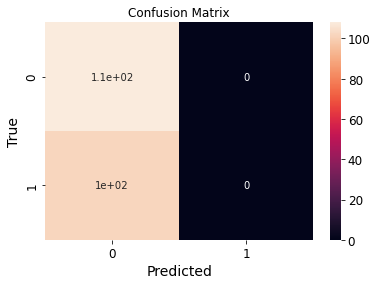



For Positive Class

f10_score for the respective class is:  0.9896253602305476
f01_score for the respective class is:  0.4882001705999431
The F1 Score for this respective class is:  0.6538461538461539
AUC Score for the respective class is: :  0.5
Precision Score for the respective class is: :  0.4857142857142857
Sensitivity/recall Score for the respective class is:  :  1.0
Specificity Score for the respective class is: :  0.0
Balanced Accuracy Score for the respective class is: :  0.5
Accuracy Score for the respective class is: :  0.4857142857142857

Confusion Matrix for the respective class



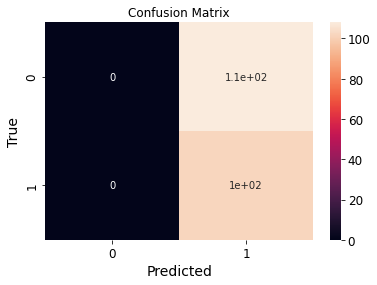



For Probability prediction class

Checking probability distribution (array([0, 1]), array([114,  96]))
f10_score for the respective class is:  0.4316239316239317
f01_score for the respective class is:  0.4580498866213152
The F1 Score for this respective class is:  0.4444444444444445
AUC Score for the respective class is: :  0.47494553376906323
Precision Score for the respective class is: :  0.4583333333333333
Sensitivity/recall Score for the respective class is:  :  0.43137254901960786
Specificity Score for the respective class is: :  0.5185185185185185
Balanced Accuracy Score for the respective class is: :  0.4749455337690632
Accuracy Score for the respective class is: :  0.47619047619047616

Confusion Matrix for the respective class



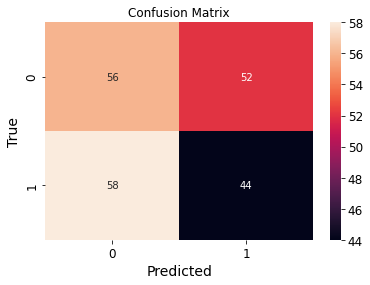

In [13]:

print("For Negative Class")
print()
data_negative = [0]*train_set.shape[0]
negative_class = pd.DataFrame(data_negative, columns=['negative_labels'])
function_for_performance_matrix(negative_class)

print("\n")
print("For Positive Class")
print()
data_positive=[1]*train_set.shape[0]
positive_class=pd.DataFrame(data_positive, columns=['positive_labels'])
function_for_performance_matrix(positive_class)

print("\n")
# Random prediction class with equal probability
print("For Probability prediction class")
print()
arr=np.array([0,1])
y_prob_pred=np.random.choice(arr,size=train_set.shape[0],p=[0.5,0.5])
check_prob=np.unique(y_prob_pred,return_counts=True)
print("Checking probability distribution",check_prob)
function_for_performance_matrix(y_prob_pred)

### Choose a performance metric

Based on the above baseline tests and the client's requirements, **choose a performance metric** to use for evaluating/driving your machine learning methods.

In [14]:
print('Based on the client requirements I would choose AUC Score because it consists of True_Positive_Rate and False_Positive_Rate, we want a high Recall and less FPR')
print("And plot of AUC gives us the relation between TPR and (1-Specificity), this statement forces me to choose AUC metric")

Based on the client requirements I would choose AUC Score because it consists of True_Positive_Rate and False_Positive_Rate, we want a high Recall and less FPR
And plot of AUC gives us the relation between TPR and (1-Specificity), this statement forces me to choose AUC metric


### SGD baseline

For a stronger baseline, **train and evaluate** the Stochastic Gradient Descent classifier.
For this baseline case use the default settings for all the hyperparameters.

In [15]:
print("We have to calculate Performance Matrix multiple times in the assignment So I am creating a function for validation_labels")
def performance_matrix_on_validation(prediction):
    print("f10_score for the respective class is: " ,f10_score(val_labels,prediction))
    print("f01_score for the respective class is: ",f01_score(val_labels,prediction))
    
#The F-beta score is the weighted harmonic mean of precision and recall, reaching its optimal value at 1 and its worst value at 0.

# beta < 1 favors precision,
# beta > 1 favors recall

    print("The F1 Score for this respective class is: ",f1_score(val_labels,prediction))
    
    tn, fp, fn, tp = confusion_matrix(val_labels,prediction).ravel()
    
    print("AUC Score for the respective class is: : ",roc_auc_score(val_labels,prediction))
    print("Precision Score for the respective class is: : ",precision_score(val_labels,prediction))
    print("Sensitivity/recall Score for the respective class is:  : ",tp/(tp+fn))
    print("Specificity Score for the respective class is: : ",tn/(tn+fp))
    print("Balanced Accuracy Score for the respective class is: : ",balanced_accuracy_score(val_labels,prediction))
    print("Accuracy Score for the respective class is: : ",accuracy_score(val_labels,prediction))
    print()
    print("Confusion Matrix for the respective class")
    print()
    cmat = confusion_matrix(y_true=val_labels, y_pred=prediction)
    sns.heatmap(cmat,annot=True)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


We have to calculate Performance Matrix multiple times in the assignment So I am creating a function for validation_labels


f10_score for the respective class is:  0.9541160593792173
f01_score for the respective class is:  0.9134366925064599
The F1 Score for this respective class is:  0.9333333333333332
AUC Score for the respective class is: :  0.9337944664031621
Precision Score for the respective class is: :  0.9130434782608695
Sensitivity/recall Score for the respective class is:  :  0.9545454545454546
Specificity Score for the respective class is: :  0.9130434782608695
Balanced Accuracy Score for the respective class is: :  0.9337944664031621
Accuracy Score for the respective class is: :  0.9333333333333333

Confusion Matrix for the respective class



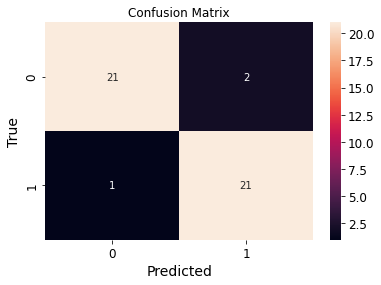

In [16]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

pipeline_sgd=Pipeline([
    ("p1",pre_pipeline),
    ("sgd_model",SGDClassifier())
])
sgd_model=pipeline_sgd.fit(training_features,training_labels)

sgd_pred=sgd_model.predict(val_features)

performance_matrix_on_validation(sgd_pred)

###  Confusion matrix

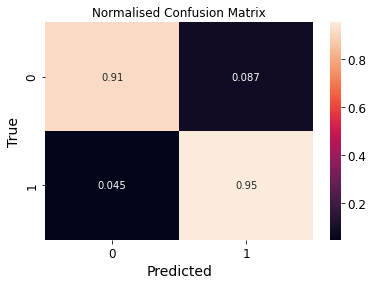

In [17]:
cmat = confusion_matrix(y_true=val_labels, y_pred=sgd_pred, normalize="true")
sns.heatmap(cmat,annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalised Confusion Matrix')
plt.show()

In [19]:
print('the probability of the False_Negative , as we are using normalised confusion matrix, the FALSE POSITIVE=0.045')
print("Here it is pretty clear that we are taking about the client's second condition")
print("Other values can also be interpreted by the confusion matrix: ")
print("TRUE POSITIVE= 0.95")
print("FALSE POSITIVE=0.087")
print("TRUE NEGATIVE=0.91")
print("So based on the results above I would say that this baseline is satisfying the criterion")

the probability of the False_Negative , as we are using normalised confusion matrix, the FALSE POSITIVE=0.045
Here it is pretty clear that we are taking about the client's second condition
Other values can also be interpreted by the confusion matrix: 
TRUE POSITIVE= 0.95
FALSE POSITIVE=0.087
TRUE NEGATIVE=0.91
So based on the results above I would say that this baseline is satisfying the criterion


###  Main classifier

**Train and optimise the hyperparameters** to give the best performance for **each of the following classifiers**:
 - KNN (K-Nearest Neighbour) classifier
 - Decision tree classifier
 - Support vector machine classifier
 - SGD classifier
 
**Display the performance of the different classifiers and the optimised hyperparameters.**

**Based on these results, list the best 3 classifiers and indicate if you think any perform equivalently.**

In [20]:
print("Train and optimize hyperparameter for KNN")

Train and optimize hyperparameter for KNN


In [21]:
from sklearn.neighbors import KNeighborsClassifier
pipeline_knn=Pipeline([
    ("p1",pre_pipeline),
    ("knn_clf",KNeighborsClassifier())
])

In [22]:
param_grid=[
    {"knn_clf__n_neighbors":np.arange(3,30,1),
#     "knn_clf__leaf_size": np.arange(1,50)      # only considering 1 hyperparameter to strike a balance between computation time and performance as it is the condition given in the question.
    },
]


grid_model_knn=pipeline_knn
grid_search=GridSearchCV(grid_model_knn,param_grid,scoring="roc_auc",
                             cv=5,return_train_score=True)

grid_search.fit(training_features,training_labels)
print(grid_search.best_params_)

{'knn_clf__n_neighbors': 9}


In [23]:
final_pipeline_knn=Pipeline([
    ("p1",pre_pipeline),
    ("knn_clf",KNeighborsClassifier(n_neighbors=9))
])

f10_score for the respective class is:  0.9541160593792173
f01_score for the respective class is:  0.9134366925064599
The F1 Score for this respective class is:  0.9333333333333332
AUC Score for the respective class is: :  0.9337944664031621
Precision Score for the respective class is: :  0.9130434782608695
Sensitivity/recall Score for the respective class is:  :  0.9545454545454546
Specificity Score for the respective class is: :  0.9130434782608695
Balanced Accuracy Score for the respective class is: :  0.9337944664031621
Accuracy Score for the respective class is: :  0.9333333333333333

Confusion Matrix for the respective class



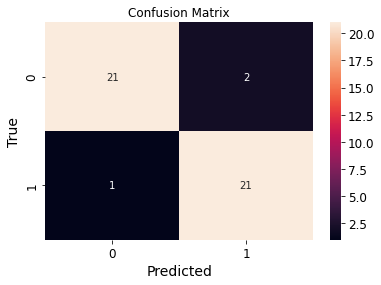

In [24]:
model_knn=final_pipeline_knn.fit(training_features,training_labels)
pred_knn=model_knn.predict(val_features)

performance_matrix_on_validation(pred_knn)

In [25]:
print("Train and optimize hyperparameter for Decision Tree Classifier")

Train and optimize hyperparameter for Decision Tree Classifier


In [26]:
from sklearn.tree import DecisionTreeClassifier
pipeline_dt=Pipeline([
    ("p1",pre_pipeline),
    ("dt_clf",DecisionTreeClassifier(random_state=42))  # using random_state so that it gives us the same values, then we can compare with the other models.
])

In [27]:
param_grid=[
    {'dt_clf__max_depth':np.linspace(1, 32, 32, endpoint=True) ,
     "dt_clf__min_samples_split":np.linspace(0.1, 1.0, 10, endpoint=True)}
]


grid_model_dt=pipeline_dt

grid_search=GridSearchCV(grid_model_dt,param_grid,scoring="roc_auc",
                             cv=5,return_train_score=True,)

grid_search.fit(training_features,training_labels)
print(grid_search.best_params_)

{'dt_clf__max_depth': 5.0, 'dt_clf__min_samples_split': 0.1}


In [28]:
final_pipeline_dt=Pipeline([
    ("p1",pre_pipeline),
    ("dt_clf",DecisionTreeClassifier(max_depth=5.0,min_samples_split=0.1))
])

f10_score for the respective class is:  0.954975236380009
f01_score for the respective class is:  0.9995287464655984
The F1 Score for this respective class is:  0.9767441860465117
AUC Score for the respective class is: :  0.9772727272727273
Precision Score for the respective class is: :  1.0
Sensitivity/recall Score for the respective class is:  :  0.9545454545454546
Specificity Score for the respective class is: :  1.0
Balanced Accuracy Score for the respective class is: :  0.9772727272727273
Accuracy Score for the respective class is: :  0.9777777777777777

Confusion Matrix for the respective class



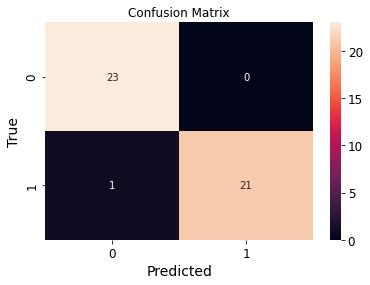

In [29]:
model_dt=final_pipeline_dt.fit(training_features,training_labels)
pred_dt=model_dt.predict(val_features)

performance_matrix_on_validation(pred_dt)

In [30]:
print("Train and optimize hyperparameter for Support Vector Machine")

Train and optimize hyperparameter for Support Vector Machine


In [31]:
from sklearn.svm import SVC
pipeline_svm=Pipeline([
    ("p1",pre_pipeline),
    ("svm_clf",SVC())
])

In [32]:
param_grid=[{
#     'svm_clf__gamma': [0.1, 1, 10, 100],
    "svm_clf__C":[0.1, 1, 10, 100, 1000]               # only considering 1 hyperparameter to strike a balance between computation time and performance as it is the condition given in the question.
#     'svm_clf__kernel':['linear', 'rbf', 'poly']
}]


grid_model_svm=pipeline_svm

grid_search=GridSearchCV(grid_model_svm,param_grid,scoring="roc_auc",
                             cv=5,return_train_score=True)

grid_search.fit(training_features,training_labels)
print(grid_search.best_params_)

{'svm_clf__C': 1}


In [33]:
final_pipeline_svc=Pipeline([
    ("p1",pre_pipeline),
    ("svm_clf",SVC(C=1))
])

f10_score for the respective class is:  0.9995501574448943
f01_score for the respective class is:  0.9569336778639105
The F1 Score for this respective class is:  0.9777777777777777
AUC Score for the respective class is: :  0.9782608695652174
Precision Score for the respective class is: :  0.9565217391304348
Sensitivity/recall Score for the respective class is:  :  1.0
Specificity Score for the respective class is: :  0.9565217391304348
Balanced Accuracy Score for the respective class is: :  0.9782608695652174
Accuracy Score for the respective class is: :  0.9777777777777777

Confusion Matrix for the respective class



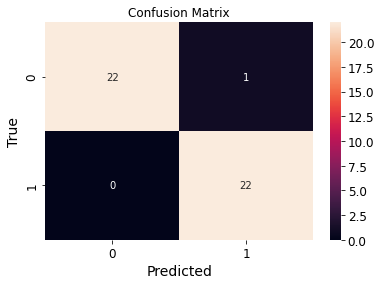

In [34]:
model_svc=final_pipeline_svc.fit(training_features,training_labels)
pred_svc=model_svc.predict(val_features)

performance_matrix_on_validation(pred_svc)

In [35]:
print("Train and optimize hyperparameter for Stochastic Gradient Descent")

Train and optimize hyperparameter for Stochastic Gradient Descent


In [36]:
from sklearn.linear_model import SGDClassifier
pipeline_sgd=Pipeline([
    ("p1",pre_pipeline),
    ("sgd_c",SGDClassifier(random_state=42))  # using random_state so that it is easy to compare
])

In [37]:
param_grid=[{
    "sgd_c__alpha" : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],

}]


grid_model_sgd=pipeline_sgd

grid_search=GridSearchCV(grid_model_sgd,param_grid,scoring="roc_auc",
                             cv=5,return_train_score=True)


grid_search.fit(training_features,training_labels)
print(grid_search.best_params_)

{'sgd_c__alpha': 0.1}


In [38]:
final_pipeline_sgd=Pipeline([
    ("p1",pre_pipeline),
    ("sgd_c",SGDClassifier(alpha=0.1))
])

f10_score for the respective class is:  0.9995501574448943
f01_score for the respective class is:  0.9569336778639105
The F1 Score for this respective class is:  0.9777777777777777
AUC Score for the respective class is: :  0.9782608695652174
Precision Score for the respective class is: :  0.9565217391304348
Sensitivity/recall Score for the respective class is:  :  1.0
Specificity Score for the respective class is: :  0.9565217391304348
Balanced Accuracy Score for the respective class is: :  0.9782608695652174
Accuracy Score for the respective class is: :  0.9777777777777777

Confusion Matrix for the respective class



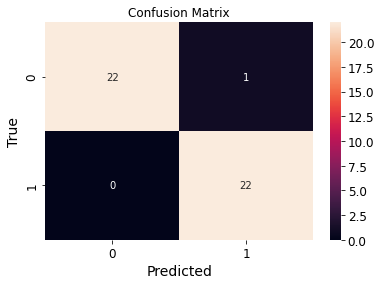

In [39]:
model_sgd=final_pipeline_sgd.fit(training_features,training_labels)
pred_sgd=model_sgd.predict(val_features)
performance_matrix_on_validation(pred_sgd)

In [40]:
# Question: Based on these results, list the best 3 classifiers and indicate if you think any perform equivalently.

# Based on the results above of the 4 models the best 3 models 
print('I think that as we are more concerned about the sensitivity and specificity so I will prefer to compare the models based on this two matrices and also the accuracy_score for further relevance')
print('My 3 Best Models are: ')
print("SGD")
print("SVC")
print('Decision Tree')
print("And I think that Decision Tree , Stocastic Gradient Descent and Support vector classifier perform equivalently.")
print('Also beacause the dataset is small, that is it has only 300 rows , so it is a little hard to choose only the one best model')

I think that as we are more concerned about the sensitivity and specificity so I will prefer to compare the models based on this two matrices and also the accuracy_score for further relevance
My 3 Best Models are: 
SGD
SVC
Decision Tree
And I think that Decision Tree , Stocastic Gradient Descent and Support vector classifier perform equivalently.
Also beacause the dataset is small, that is it has only 300 rows , so it is a little hard to choose only the one best model


### 2.7 Model selection

**Choose the best classifier**

In [41]:

'''Based on the client requirnment we say that the sensitivity >95% and specificity >90%, so I will choose SVC'''

print('I Would say that as per the results of the performance matrices I would choose Support Vector Classifier although the performance of the models(Decision Tree, SVC and SGD) are pretty equivalent but Stochastic Gradient Descent and decision tree does not give the same value for hyperparameter everytime, we have to use random state.')
print("Support Vector Machine and K-nearest_neighbour give us the same hyperparameter evertime, so on comparing these two models we can clearly see that the SVC gives us the best/much_more_accurate result")
print()
print("SO I WOULD CHOOSE SUPPORT VECTOR CLASSIFIER AS THE BEST CLASSIFIER")
print('Also the client requirnments are fully satisfied,  sensitivity >95% and specificity >90%')
print("For SVC I am only choosing one hyperparameter that is 'C' as in the question we are given a condition that we have to strike a balance between computation time and performance.")
print("As we know that 'C' is the penalty term, it allows misclassification and default value of C is 1.0 also I read it somewhere that the while setting the range for C in param_grid of grid search we should put it in the power of 10, for example 1,10,100, etc... ")

I Would say that as per the results of the performance matrices I would choose Support Vector Classifier although the performance of the models(Decision Tree, SVC and SGD) are pretty equivalent but Stochastic Gradient Descent and decision tree does not give the same value for hyperparameter everytime, we have to use random state.
Support Vector Machine and K-nearest_neighbour give us the same hyperparameter evertime, so on comparing these two models we can clearly see that the SVC gives us the best/much_more_accurate result

SO I WOULD CHOOSE SUPPORT VECTOR CLASSIFIER AS THE BEST CLASSIFIER
Also the client requirnments are fully satisfied,  sensitivity >95% and specificity >90%
For SVC I am only choosing one hyperparameter that is 'C' as in the question we are given a condition that we have to strike a balance between computation time and performance.
As we know that 'C' is the penalty term, it allows misclassification and default value of C is 1.0 also I read it somewhere that the whi

### Final performance

**Calculate and display an unbiased performance measure that you can present to the client.**

**Is your chosen classifier underfitting or overfitting?**

**Does your chosen classifier meet the client's performance criteria?**

In [42]:
print("I am creating a function for performance matrix on test data, as we have to calculate it multiple times in the assignment")
def performance_matrix_on_testing_data(prediction):
    print("f10_score for the respective class is: " ,f10_score(testing_labels,prediction))
    print("f01_score for the respective class is: ",f01_score(testing_labels,prediction))
    
#The F-beta score is the weighted harmonic mean of precision and recall, reaching its optimal value at 1 and its worst value at 0.

# beta < 1 favors precision,
# beta > 1 favors recall

    print("The F1 Score for this respective class is: ",f1_score(testing_labels,prediction))
    
    tn, fp, fn, tp = confusion_matrix(testing_labels,prediction).ravel()
    
    print("AUC Score for the respective class is: : ",roc_auc_score(testing_labels,prediction))
    print("Precision Score for the respective class is: : ",precision_score(testing_labels,prediction))
    print("Sensitivity/recall Score for the respective class is:  : ",tp/(tp+fn))
    print("Specificity Score for the respective class is: : ",tn/(tn+fp))
    print("Balanced Accuracy Score for the respective class is: : ",balanced_accuracy_score(testing_labels,prediction))
    print("Accuracy Score for the respective class is: : ",accuracy_score(testing_labels,prediction))
    print()
    print("Confusion Matrix for the respective class")
    print()
    cmat = confusion_matrix(y_true=testing_labels, y_pred=prediction)
    sns.heatmap(cmat,annot=True)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

I am creating a function for performance matrix on test data, as we have to calculate it multiple times in the assignment


In [43]:
print("It is a good practice to include training and validation data for predicting on testing data")
tr_val_features = pd.concat([training_features,val_features],axis=0)
# tr_val_features.shape
tr_val_labels=pd.concat([training_labels,val_labels],axis=0)
# tr_val_labels.shape

It is a good practice to include training and validation data for predicting on testing data


I am using SVC() here for calculating unbaised performance matrix

f10_score for the respective class is:  0.954975236380009
f01_score for the respective class is:  0.9995287464655984
The F1 Score for this respective class is:  0.9767441860465117
AUC Score for the respective class is: :  0.9772727272727273
Precision Score for the respective class is: :  1.0
Sensitivity/recall Score for the respective class is:  :  0.9545454545454546
Specificity Score for the respective class is: :  1.0
Balanced Accuracy Score for the respective class is: :  0.9772727272727273
Accuracy Score for the respective class is: :  0.9777777777777777

Confusion Matrix for the respective class



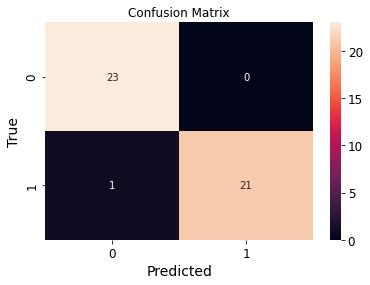


So here we see that the values of different performance matrix as obtained on the test set are very much similar to the values obtained on validation set, which means our model is NEITHER OVERFITTING NOR UNDERFITTING
As per the two requirnments of the client, which are: 
Requirnment 1: 
Have atleast 95% probability of detecting malignant cancer: which means that True_Positive_rate should be greater than or equal to 95%
Requirnment 2: 
Have no more than 10% of healthy cases labelled as positive: which means that specificity should be greater than or equal to 90%
The chosen classifier meets the client's performance criteria as the Sensitivity is greater than 95% and specificity is also greater than 90% 
So yes, the chosen classifer meets the clients requirnment
✌️


In [44]:
print('I am using SVC() here for calculating unbaised performance matrix')
print()
model_svc=final_pipeline_svc.fit(tr_val_features,tr_val_labels)
pred_svc=model_svc.predict(testing_features)

performance_matrix_on_testing_data(pred_svc)

print()
print("So here we see that the values of different performance matrix as obtained on the test set are very much similar to the values obtained on validation set, which means our model is NEITHER OVERFITTING NOR UNDERFITTING")
print("As per the two requirnments of the client, which are: ")
print("Requirnment 1: ")
print("Have atleast 95% probability of detecting malignant cancer: which means that True_Positive_rate should be greater than or equal to 95%")
print("Requirnment 2: ")
print("Have no more than 10% of healthy cases labelled as positive: which means that specificity should be greater than or equal to 90%")

print("The chosen classifier meets the client's performance criteria as the Sensitivity is greater than 95% and specificity is also greater than 90% ")
print("So yes, the chosen classifer meets the clients requirnment")
print("✌️")

## 3. Decision Boundaries

### 3.1 Rank features

Although it is only possible to know the true usefulness of a feature when you've combined it with others in a machine learning method, it is still helpful to have some measure for how discriminative each feature is on its own.  One common method for doing this is to calculate a T-score (often used in statistics, and in the LDA machine learning method) for each feature.  

The formula for the T-score is (mean(x2) - mean(x1))/(0.5*(stddev(x2) + stddev(x1))), where x1 and x2 are the datasets corresponding to the two classes. Large values for the T-score (either positive or negative) indicate discriminative ability.

**Calculate the T-score for each feature and print out the best 4 features according to this score.**

In [45]:
health_data_benign=health_data.loc[health_data['label']==0]
health_data_malignant=health_data.loc[health_data['label']==1]

T_score=abs(health_data_benign.mean() - health_data_malignant.mean())/(0.5*(np.std(health_data_benign) + np.std(health_data_malignant)))
T_score_sorted_values=T_score.sort_values(ascending=False)   # Sorting pandas Series

print("Four featues with best T_Scores are:",T_score_sorted_values[1:5])

Four featues with best T_Scores are: worst concave points    2.495529
worst perimeter         2.481440
worst radius            2.418996
mean concave points     2.236978
dtype: float64


### 3.2 Visualise decision boundaries [2.5 marks]

**Display the decision boundaries** for each pair of features from the best 4 chosen above.

Instead of using the simple mean as the input for `xmean` in `plot_contours`, use the following: 0.5*(mean(x1) + mean(x2)), where x1 and x2 are the data associated with the two classes.  This way of calculating a "mean" point takes into account any imbalance between the classes.

In [46]:
# Getting numpy array from data frame
health_data_benign_np=health_data_benign.iloc[:,1:].values        # Because the function requires a numpy array
health_data_malignant_np=health_data_malignant.iloc[:,1:].values  # Because the function requires a numpy array

In [47]:
def make_meshgrid(x, y, ns=100):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on (only min and max used)
    y: data to base y-axis meshgrid on (only min and max used)
    ns: number of steps in grid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    hx = (x_max - x_min)/ns
    hy = (y_max - y_min)/ns
    xx, yy = np.meshgrid(np.arange(x_min, x_max + hx, hx), np.arange(y_min, y_max + hy, hy))
    return xx, yy

In [48]:
def plot_contours(clf, xx, yy, xmean, n1, n2, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    xmean : 1d array of mean values (to populate constant features with)
    n1, n2: index numbers of features that change (for xx and yy)
    params: dictionary of params to pass to contourf, optional
    """
    # The following lines makes an MxN matrix to pass to the classifier (# samples x # features)
    # It does this by multiplying Mx1 and 1xN matrices, where the former is filled with 1's
    #  where M is the number of grid points in xx and N is the number of features in xmean
    #  It is done in such a way that the xmean vector is replaced in each row
    fullx = np.ones((xx.ravel().shape[0],1)) * np.reshape(xmean,(1,-1))
    fullx[:,n1] = xx.ravel()
    fullx[:,n2] = yy.ravel()
    Z = clf.predict(fullx)
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    return out

/Users/rishabh/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


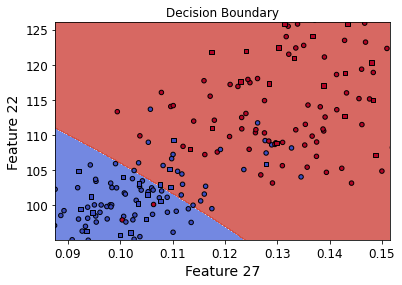

In [49]:

X_mean=0.5*(np.mean(health_data_benign_np,axis=0) + np.mean(health_data_malignant_np,axis=0))


n0=27  # mean radius 
n1=22  # mean texture

x10, x90 = np.percentile(training_features.values[:,n0],[10,90])
y10, y90 = np.percentile(training_features.values[:,n1],[10,90])
xx, yy = make_meshgrid(np.array([x10, x90]), np.array([y10, y90]), 500)

plot_contours(final_pipeline_svc, xx, yy, X_mean, n0, n1, cmap=plt.cm.coolwarm, alpha=0.8)

plt.scatter(training_features.values[:,n0], training_features.values[:,n1], c=training_labels.values, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
plt.scatter(val_features.values[:,n0], val_features.values[:,n1], c=val_labels.values, cmap=plt.cm.coolwarm, s=20, edgecolors="k", marker='s')


# plt.rcParams["figure.figsize"] = (10,5)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel(f"Feature {n0}")
plt.ylabel(f"Feature {n1}")
plt.title("Decision Boundary")

plt.show()

/Users/rishabh/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


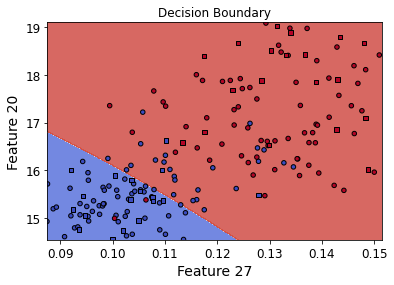

In [50]:

X_mean= 0.5*(np.mean(health_data_benign_np,axis=0) + np.mean(health_data_malignant_np,axis=0))

n0=27  # worst concave points 
n1=20   # Worst_radius


x10, x90 = np.percentile(training_features.values[:,n0],[10,90])
y10, y90 = np.percentile(training_features.values[:,n1],[10,90])
xx, yy = make_meshgrid(np.array([x10, x90]), np.array([y10, y90]), 500)

plot_contours(final_pipeline_svc, xx, yy, X_mean, n0, n1, cmap=plt.cm.coolwarm, alpha=0.8)

plt.scatter(training_features.values[:,n0], training_features.values[:,n1], c=training_labels.values, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
plt.scatter(val_features.values[:,n0], val_features.values[:,n1], c=val_labels.values, cmap=plt.cm.coolwarm, s=20, edgecolors="k", marker='s')


# plt.rcParams["figure.figsize"] = (10,5)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel(f"Feature {n0}")
plt.ylabel(f"Feature {n1}")
plt.title("Decision Boundary")

plt.show()

/Users/rishabh/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


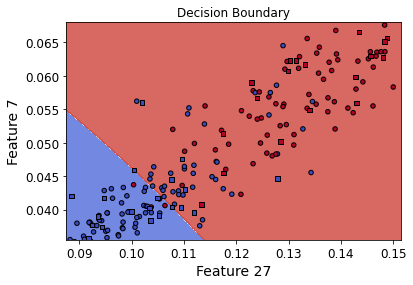

In [51]:
X_mean=0.5*(np.mean(health_data_benign_np,axis=0) + np.mean(health_data_malignant_np,axis=0))

n0=27  # worst concave points 
n1=7   # mean_concave point


x10, x90 = np.percentile(training_features.values[:,n0],[10,90])
y10, y90 = np.percentile(training_features.values[:,n1],[10,90])
xx, yy = make_meshgrid(np.array([x10, x90]), np.array([y10, y90]), 500)

plot_contours(final_pipeline_svc, xx, yy, X_mean, n0, n1, cmap=plt.cm.coolwarm, alpha=0.8)

plt.scatter(training_features.values[:,n0], training_features.values[:,n1], c=training_labels.values, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
plt.scatter(val_features.values[:,n0], val_features.values[:,n1], c=val_labels.values, cmap=plt.cm.coolwarm, s=20, edgecolors="k", marker='s')


# plt.rcParams["figure.figsize"] = (10,5)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel(f"Feature {n0}")
plt.ylabel(f"Feature {n1}")
plt.title("Decision Boundary")

plt.show()

/Users/rishabh/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


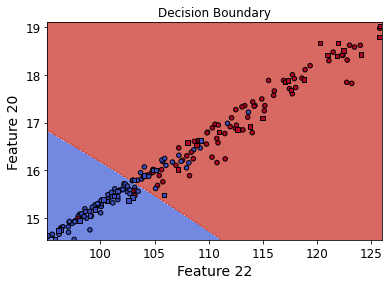

In [52]:
X_mean=0.5*(np.mean(health_data_benign_np,axis=0) + np.mean(health_data_malignant_np,axis=0))

n0=22  # worst_perimeter
n1=20   # worst_radius


x10, x90 = np.percentile(training_features.values[:,n0],[10,90])
y10, y90 = np.percentile(training_features.values[:,n1],[10,90])
xx, yy = make_meshgrid(np.array([x10, x90]), np.array([y10, y90]), 500)

plot_contours(final_pipeline_svc, xx, yy, X_mean, n0, n1, cmap=plt.cm.coolwarm, alpha=0.8)

plt.scatter(training_features.values[:,n0], training_features.values[:,n1], c=training_labels.values, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
plt.scatter(val_features.values[:,n0], val_features.values[:,n1], c=val_labels.values, cmap=plt.cm.coolwarm, s=20, edgecolors="k", marker='s')


# plt.rcParams["figure.figsize"] = (10,5)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel(f"Feature {n0}")
plt.ylabel(f"Feature {n1}")
plt.title("Decision Boundary")

plt.show()

/Users/rishabh/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


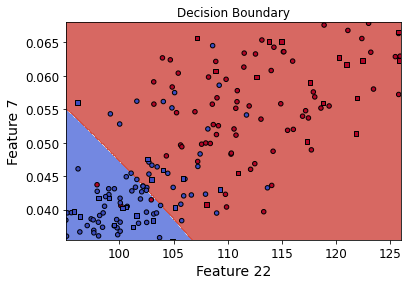

In [53]:
X_mean=0.5*(np.mean(health_data_benign_np,axis=0) + np.mean(health_data_malignant_np,axis=0))

n0=22  # worst_perimeter
n1=7   # mean_concave_point


x10, x90 = np.percentile(training_features.values[:,n0],[10,90])
y10, y90 = np.percentile(training_features.values[:,n1],[10,90])
xx, yy = make_meshgrid(np.array([x10, x90]), np.array([y10, y90]), 500)

plot_contours(final_pipeline_svc, xx, yy, X_mean, n0, n1, cmap=plt.cm.coolwarm, alpha=0.8)

plt.scatter(training_features.values[:,n0], training_features.values[:,n1], c=training_labels.values, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
plt.scatter(val_features.values[:,n0], val_features.values[:,n1], c=val_labels.values, cmap=plt.cm.coolwarm, s=20, edgecolors="k", marker='s')


# plt.rcParams["figure.figsize"] = (10,5)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel(f"Feature {n0}")
plt.ylabel(f"Feature {n1}")
plt.title("Decision Boundary")

plt.show()

/Users/rishabh/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


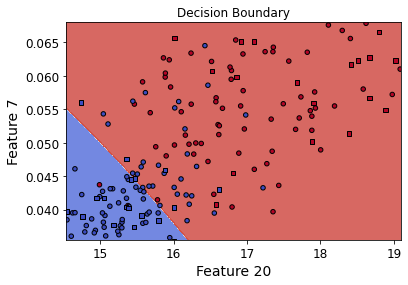

In [54]:
X_mean=0.5*(np.mean(health_data_benign_np,axis=0) + np.mean(health_data_malignant_np,axis=0))

n0=20  # worst_radius
n1=7   # mean_concave_point


x10, x90 = np.percentile(training_features.values[:,n0],[10,90])
y10, y90 = np.percentile(training_features.values[:,n1],[10,90])
xx, yy = make_meshgrid(np.array([x10, x90]), np.array([y10, y90]), 500)

plot_contours(final_pipeline_svc, xx, yy, X_mean, n0, n1, cmap=plt.cm.coolwarm, alpha=0.8)

plt.scatter(training_features.values[:,n0], training_features.values[:,n1], c=training_labels.values, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
plt.scatter(val_features.values[:,n0], val_features.values[:,n1], c=val_labels.values, cmap=plt.cm.coolwarm, s=20, edgecolors="k", marker='s')


# plt.rcParams["figure.figsize"] = (10,5)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel(f"Feature {n0}")
plt.ylabel(f"Feature {n1}")
plt.title("Decision Boundary")

plt.show()

### Interpretation

From the decision boundaries displayed above, **would you expect the method to extrapolate well or not**?  Give reasons for your answer.

In [55]:
# Your answer here
print("From the Decision Boundaries above, I can say that I will expect the method to extrapolate well as we can see that it is able to classify two classes separately pretty well. ")
print(" As we have two classes: Red and Blue")
print("It is clearly visible that most of the blue dots are in the blue area and most of thr red dots are in the red area ")
print("And it is not True for only one feature, we used 4 features and plotted 6 plots and all of them extrapolated well")

From the Decision Boundaries above, I can say that I will expect the method to extrapolate well as we can see that it is able to classify two classes separately pretty well. 
 As we have two classes: Red and Blue
It is clearly visible that most of the blue dots are in the blue area and most of thr red dots are in the red area 
And it is not True for only one feature, we used 4 features and plotted 6 plots and all of them extrapolated well


## Second Round

After presenting your initial results to the client they come back to you and say that they have done some financial analysis and it would save them a lot of time and money if they did not have to analyse every cell, which is needed to get the "worst" features. Instead, they can quickly get accurate estimates for the "mean" and "standard error" features from a much smaller, randomly selected set of cells.

They ask you to **give them a performance estimate for the same problem, but without using any of the "worst" features.**



In [56]:
# labels would be the same so lets only modify training,testing and validation features
new_training_features=training_features.iloc[:,:20]
new_validation_features=val_features.iloc[:,:20]
new_testing_features=testing_features.iloc[:,:20]

In [57]:
print('Train and optimize hyperparameter for KNN on NEW DATASET')

Train and optimize hyperparameter for KNN on NEW DATASET


In [58]:
pipeline_knn_new_dataset=Pipeline([
    ("p1",pre_pipeline),
    ("knn_clf",KNeighborsClassifier())
])

In [59]:
param_grid=[
    {"knn_clf__n_neighbors":np.arange(3,30,1) #  only considering 1 hyperparameter to strike a balance between computation time and performance.
#     "knn_clf__leaf_size": np.arange(1,50)
    }
]
grid_model_knn_new_dataset= pipeline_knn_new_dataset
grid_search=GridSearchCV(grid_model_knn_new_dataset,param_grid,scoring="roc_auc",
                             cv=5,return_train_score=True)

grid_search.fit(new_training_features,training_labels)
print(grid_search.best_params_)

{'knn_clf__n_neighbors': 7}


In [60]:
final_pipeline_knn_new=Pipeline([
    ("p1",pre_pipeline),
    ("knn_clf",KNeighborsClassifier(n_neighbors=7))
])

In [61]:
model_knn_new_dataset=final_pipeline_knn_new.fit(new_training_features,training_labels)
pred_knn_new=model_knn_new_dataset.predict(new_validation_features)

f10_score for the respective class is:  0.8644144144144144
f01_score for the respective class is:  0.9490603363006923
The F1 Score for this respective class is:  0.9047619047619048
AUC Score for the respective class is: :  0.9100790513833993
Precision Score for the respective class is: :  0.95
Sensitivity/recall Score for the respective class is:  :  0.8636363636363636
Specificity Score for the respective class is: :  0.9565217391304348
Balanced Accuracy Score for the respective class is: :  0.9100790513833992
Accuracy Score for the respective class is: :  0.9111111111111111

Confusion Matrix for the respective class



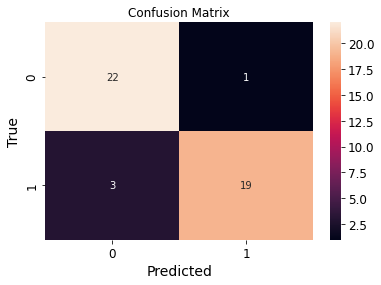

In [62]:
performance_matrix_on_validation(pred_knn_new)

In [63]:
print("Train and optimize hyperparameter for Decision Tree Classifier on NEW DATASET")

Train and optimize hyperparameter for Decision Tree Classifier on NEW DATASET


In [64]:
pipeline_dt_new_dataset=Pipeline([
    ("p1",pre_pipeline),
    ("dt_clf",DecisionTreeClassifier(random_state=42))
])

In [65]:

param_grid=[
    {'dt_clf__max_depth':np.linspace(1, 32, 32, endpoint=True) ,
     "dt_clf__min_samples_split":np.linspace(0.1, 1.0, 10, endpoint=True)}
]


grid_model_dt_new_dataset=pipeline_dt_new_dataset

grid_search=GridSearchCV(grid_model_dt_new_dataset  ,param_grid,scoring="roc_auc",
                             cv=10,return_train_score=True)

grid_search.fit(new_training_features,training_labels)
print(grid_search.best_params_)


{'dt_clf__max_depth': 2.0, 'dt_clf__min_samples_split': 0.1}


In [66]:
final_pipeline_dt_new_dataset=Pipeline([
    ("p1",pre_pipeline),
    ("dt_clf",DecisionTreeClassifier(max_depth=2.0,min_samples_split=0.1))
])

In [67]:
model_dt_new_dataset=final_pipeline_dt_new_dataset.fit(new_training_features,training_labels)
pred_dt_new_dataset=model_dt_new_dataset.predict(new_validation_features)

f10_score for the respective class is:  0.9536870503597122
f01_score for the respective class is:  0.8757225433526011
The F1 Score for this respective class is:  0.9130434782608695
AUC Score for the respective class is: :  0.9120553359683794
Precision Score for the respective class is: :  0.875
Sensitivity/recall Score for the respective class is:  :  0.9545454545454546
Specificity Score for the respective class is: :  0.8695652173913043
Balanced Accuracy Score for the respective class is: :  0.9120553359683794
Accuracy Score for the respective class is: :  0.9111111111111111

Confusion Matrix for the respective class



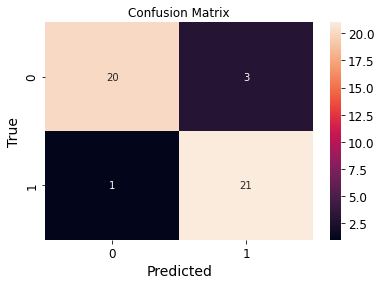

In [68]:
performance_matrix_on_validation(pred_dt_new_dataset)

In [69]:
print("Train and optimize hyperparameter for Support Vector Machine on new Dataset")

Train and optimize hyperparameter for Support Vector Machine on new Dataset


In [70]:
pipeline_svm_new_dataset=Pipeline([
    ("p1",pre_pipeline),
    ("svm_clf",SVC())
])

In [71]:

param_grid=[{
#     'svm_clf__gamma': [0.1, 1, 10, 100], 
    "svm_clf__C":[0.1, 1, 10, 100, 1000],   #only considering 1 hyperparameter to strike a balance between computation time and performance
#     'svm_clf__kernel':['linear', 'rbf', 'poly']
}]



grid_model=pipeline_svm_new_dataset

grid_search=GridSearchCV(grid_model, param_grid,scoring="roc_auc",
                             cv=10,return_train_score=True)

grid_search.fit(new_training_features,training_labels)
print(grid_search.best_params_)

{'svm_clf__C': 10}


In [72]:
final_pipeline_svc_new_dataset=Pipeline([
    ("p1",pre_pipeline),
    ("svm_clf",SVC(C=10))   
])

In [73]:
model_svc_new_dataset=final_pipeline_svc_new_dataset.fit(new_training_features,training_labels)
pred_svc=model_svc_new_dataset.predict(new_validation_features)

f10_score for the respective class is:  0.9541160593792173
f01_score for the respective class is:  0.9134366925064599
The F1 Score for this respective class is:  0.9333333333333332
AUC Score for the respective class is: :  0.9337944664031621
Precision Score for the respective class is: :  0.9130434782608695
Sensitivity/recall Score for the respective class is:  :  0.9545454545454546
Specificity Score for the respective class is: :  0.9130434782608695
Balanced Accuracy Score for the respective class is: :  0.9337944664031621
Accuracy Score for the respective class is: :  0.9333333333333333

Confusion Matrix for the respective class



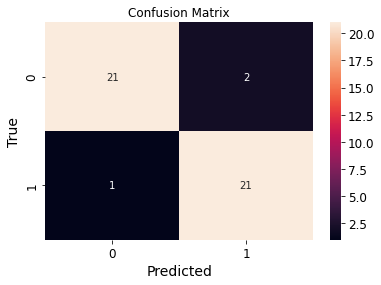

In [74]:
performance_matrix_on_validation(pred_svc)

In [75]:
print("Train and optimize hyperparameter for Stochastic Gradient Descent on new Dataset")

Train and optimize hyperparameter for Stochastic Gradient Descent on new Dataset


In [76]:
pipeline_sgd_new_dataset=Pipeline([
    ("p1",pre_pipeline),
    ("sgd_c",SGDClassifier(random_state=42))
])

In [77]:

param_grid=[{
    "sgd_c__alpha" : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],

}]

grid_model=pipeline_sgd_new_dataset

grid_search=GridSearchCV(grid_model,param_grid,scoring="roc_auc",
                             cv=10,return_train_score=True)

grid_search.fit(new_training_features,training_labels)
print(grid_search.best_params_)

{'sgd_c__alpha': 0.1}


In [78]:
final_pipeline_sgd_new_dataset=Pipeline([
    ("p1",pre_pipeline), 
    ("svm_sgd",SGDClassifier(alpha=0.1))
])

In [79]:
model_sgd_new_dataset=final_pipeline_sgd_new_dataset.fit(new_training_features,training_labels)
pred_sgd=model_sgd_new_dataset.predict(new_validation_features)

f10_score for the respective class is:  0.9090909090909091
f01_score for the respective class is:  0.9090909090909092
The F1 Score for this respective class is:  0.9090909090909091
AUC Score for the respective class is: :  0.9110671936758894
Precision Score for the respective class is: :  0.9090909090909091
Sensitivity/recall Score for the respective class is:  :  0.9090909090909091
Specificity Score for the respective class is: :  0.9130434782608695
Balanced Accuracy Score for the respective class is: :  0.9110671936758893
Accuracy Score for the respective class is: :  0.9111111111111111

Confusion Matrix for the respective class



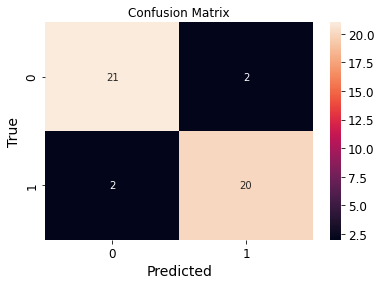

In [80]:
performance_matrix_on_validation(pred_sgd)

### 4.1 New estimate

**Calculate an unbiased performance estimate** for this new problem, as requested by the client.

In [81]:
print("It is a good practice to include training and validation data for predicting on testing data")

tr_val_features_no_worst = pd.concat([new_training_features,new_validation_features],axis=0)
# print(tr_val_features.shape)
tr_val_labels_no_worst=pd.concat([training_labels,val_labels],axis=0)
# print(tr_val_labels.shape)

It is a good practice to include training and validation data for predicting on testing data


In [82]:
print("It is a good practice to include training and validation data for predicting on testing data")

print("Unbaised performance for KNN on reduced dataset")
testing_model_knn_new_dataset=final_pipeline_knn_new.fit(tr_val_features_no_worst,tr_val_labels_no_worst)
pred_knn_new=testing_model_knn_new_dataset.predict(new_testing_features)

It is a good practice to include training and validation data for predicting on testing data
Unbaised performance for KNN on reduced dataset


f10_score for the respective class is:  0.954975236380009
f01_score for the respective class is:  0.9995287464655984
The F1 Score for this respective class is:  0.9767441860465117
AUC Score for the respective class is: :  0.9772727272727273
Precision Score for the respective class is: :  1.0
Sensitivity/recall Score for the respective class is:  :  0.9545454545454546
Specificity Score for the respective class is: :  1.0
Balanced Accuracy Score for the respective class is: :  0.9772727272727273
Accuracy Score for the respective class is: :  0.9777777777777777

Confusion Matrix for the respective class



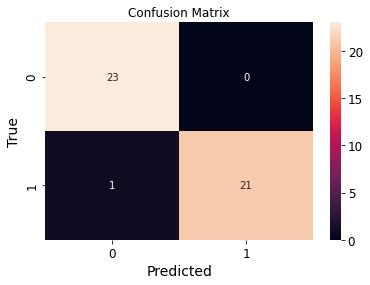

In [83]:
performance_matrix_on_testing_data(pred_knn_new)

In [84]:
print("Unbiased performance for Decision Tree")
print("It is a good practice to include training and validation data for predicting on testing data")
model_dt_new_dataset=final_pipeline_dt_new_dataset.fit(tr_val_features_no_worst,tr_val_labels_no_worst)
pred_dt_new_dataset=model_dt_new_dataset.predict(new_testing_features)

Unbiased performance for Decision Tree
It is a good practice to include training and validation data for predicting on testing data


f10_score for the respective class is:  0.9095002251238181
f01_score for the respective class is:  0.9519321394910462
The F1 Score for this respective class is:  0.9302325581395349
AUC Score for the respective class is: :  0.932806324110672
Precision Score for the respective class is: :  0.9523809523809523
Sensitivity/recall Score for the respective class is:  :  0.9090909090909091
Specificity Score for the respective class is: :  0.9565217391304348
Balanced Accuracy Score for the respective class is: :  0.9328063241106719
Accuracy Score for the respective class is: :  0.9333333333333333

Confusion Matrix for the respective class



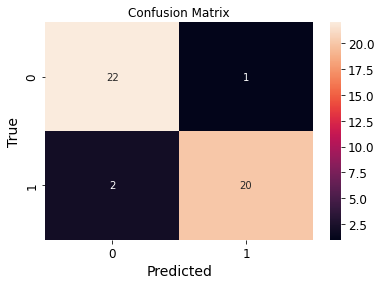

In [85]:
performance_matrix_on_testing_data(pred_dt_new_dataset)

In [86]:
print("Unbiased performance for SVC")
print("It is a good practice to include training and validation data for predicting on testing data")
model_svc_new_dataset=final_pipeline_svc_new_dataset.fit(tr_val_features_no_worst,tr_val_labels_no_worst)
pred_svc=model_svc_new_dataset.predict(new_testing_features)

Unbiased performance for SVC
It is a good practice to include training and validation data for predicting on testing data


f10_score for the respective class is:  0.9099099099099098
f01_score for the respective class is:  0.9990108803165183
The F1 Score for this respective class is:  0.9523809523809523
AUC Score for the respective class is: :  0.9545454545454546
Precision Score for the respective class is: :  1.0
Sensitivity/recall Score for the respective class is:  :  0.9090909090909091
Specificity Score for the respective class is: :  1.0
Balanced Accuracy Score for the respective class is: :  0.9545454545454546
Accuracy Score for the respective class is: :  0.9555555555555556

Confusion Matrix for the respective class



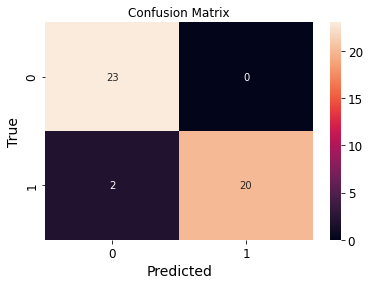

In [87]:
performance_matrix_on_testing_data(pred_svc)

In [88]:
print("Unbiased performance matrix for SGD")
print("It is a good practice to include training and validation data for predicting on testing data")
model_sgd_new_dataset=final_pipeline_sgd_new_dataset.fit(tr_val_features_no_worst,tr_val_labels_no_worst)
pred_sgd=model_sgd_new_dataset.predict(new_testing_features)

Unbiased performance matrix for SGD
It is a good practice to include training and validation data for predicting on testing data


f10_score for the respective class is:  0.954975236380009
f01_score for the respective class is:  0.9995287464655984
The F1 Score for this respective class is:  0.9767441860465117
AUC Score for the respective class is: :  0.9772727272727273
Precision Score for the respective class is: :  1.0
Sensitivity/recall Score for the respective class is:  :  0.9545454545454546
Specificity Score for the respective class is: :  1.0
Balanced Accuracy Score for the respective class is: :  0.9772727272727273
Accuracy Score for the respective class is: :  0.9777777777777777

Confusion Matrix for the respective class



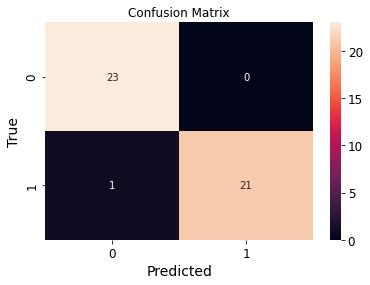

In [89]:
performance_matrix_on_testing_data(pred_sgd)

### 4.2 Performance difference

Do you think the new classifier, that does not use the "worst" features, is:
 - **as good as the previous classifier** (that uses all the features)
 - **better than the previous classifier**
 - **worse than the previous classifier**
 
Give reasons for your answer.

In [91]:
print("I think that new classifier is as good as the previous classifier \n")
print('After comparing the different performance matrix of both the classifer we see that there is not a significant difference ')
print("I was trying to compare all the performance matrix to understand the concepts deeply but for the assignment I was more focused on the AUC score, Sensitivity and Specificity as per the conditions of the client ")
print()
print("Based on the above mentioned performance matrices I did not find any noticiable result ")
print("Also the dataset small with 300 rows, with a dataset of this length it is hard give results with high confidence")

I think that new classifier is as good as the previous classifier 

After comparing the different performance matrix of both the classifer we see that there is not a significant difference 
I was trying to compare all the performance matrix to understand the concepts deeply but for the assignment I was more focused on the AUC score, Sensitivity and Specificity as per the conditions of the client 

Based on the above mentioned performance matrices I did not find any noticiable result 
Also the dataset small with 300 rows, with a dataset of this length it is hard give results with high confidence
